<div style="text-align: center;">
<h1>Final Project: Motion Deblurring</font></h1>
<h2>Course: Machine Learning</font></h2>

<center><img src="./images/unibo.png" alt="unibo_logo" width="200"/></center>

<h3>Professor: Andrea Asperti</font></h3>
<h3>University: Università degli Studi di Bologna</font></h3>
<h3>Author: Lluis Barca Pons</font></h3>
<h3>Date: 2024-01-15</font></h3>
</div>

***

 ### <font color='BB2E29'>Table of contents<font><a class='anchor' id='top'></a>
1. [Introduction](#1)
   - [Project Overview](#1.1)
   - [Dataset Description](#1.2)
2. [Setup](#2)
3. [Data Loading and Preprocessing](#3)

[<h1 align="center"><font color='BB2E29'>1. Introduction</font></h1>](#1)

[<h2> <font color='black'>1.1. Project Overview</font></h2>](#1.1)

In this project, our primary objective is to achieve the challenge of motion deblurring in images. Motion blur is a common issue in photography and occurs when the camera or subject moves during the capture of a photo, resulting in a smeared or blurred appearance. This effect can often degrade the quality of an image and obscure details.

The goal is to develop and implement a machine learning model that can effectively deblur such images, restoring them to a clearer state. This process involves not only the removal of blur but also the preservation of underlying image details.

[<h2> <font color='gray'>1.2. Dataset Description</font></h2>](#1.2)

We will be using the MNIST dataset, which is a widely recognized collection of handwritten digits commonly used in image processing and machine learning. Each image in the dataset is a 28x28 grayscale representation of digits from 0 to 9.

## 1.3. Challenge Specifics

For this project, the challenge involves artificially introducing motion blur into these MNIST images. The blurring process mimics the effect of a shaky hand or a moving camera. Our task will be to reverse this blurring – effectively developing a deblurring algorithm that can recover the original, unblurred image.

This project will encompass various stages, including data preparation, model development, training, and evaluation. The success of the deblurring algorithm will be quantitatively assessed using the Mean Squared Error (MSE) metric, comparing the deblurred images with the original, unaltered images from the MNIST dataset.

[<h1 align="center"><font color='green'>2. Setup</font></h1>](#2)

This section involves setting up the necessary environment for our motion deblurring project. It includes importing required libraries and setting some initial parameters that will be used throughout the notebook.

## 2.1. Import Libraries

First, we'll import all the necessary libraries. This includes libraries for data manipulation, machine learning, and visualization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2024-01-11 21:33:09.129902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.2. Configure Parameters

Here, we can set some global configuration parameters that will be used in the notebook. This could include settings related to image processing, model training, etc.

In [2]:
batch_size = 10000  # Number of samples in each batch
image_size = (28, 28)  # Size of the images in the MNIST dataset

# 3. Data Loading and Preprocessing

In this section, we will load the MNIST dataset and perform necessary preprocessing steps to prepare the data for our deblurring model.

## 3.1. Load the MNIST Dataset

The MNIST dataset is a collection of 28x28 grayscale images of handwritten digits (0-9), as we said. It's widely used for benchmarking image processing systems. We will load this dataset using TensorFlow/Keras utilities.

In [3]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Display the shape of the datasets
print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)

Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)


## 3.2. Preprocess the Data

Before feeding the data into our model, we need to preprocess it. This usually involves normalizing the pixel values.

In [4]:
# Normalize the pixel values to the range 0-1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

It's often useful to visualize some of the data points to understand what our dataset looks like. Let's plot a few images from the MNIST dataset.

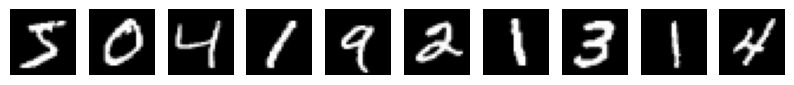

In [5]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

# Function to display images
def display_images(images, num_images=10):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Display a few images from the dataset
display_images(x_train)

# 4. Blurred Image Generation 

In this section, we will define and utilize a function to artificially introduce motion blur into the MNIST images. This step is crucial for simulating the effect we aim to deblur later.

## 4.1. Define function to generate blurred images

We will create a `generator` function as per the project requirements. This function will take images from the MNIST dataset and apply a motion blur effect. The specifics of the blurring process (like the number of moves and the range of translations) should align with the project guidelines.

In [6]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      # RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)

## 4.2. Generate blurred images examples

Let's generate a sample batch of blurred images and visualize them to understand the effect of our blurring function.

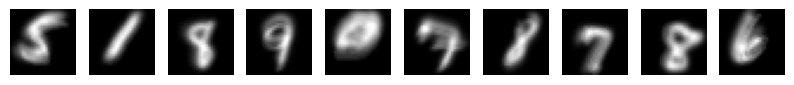

In [7]:
# Generate a sample batch of blurred images
sample_blurred, sample_original = next(generator(x_train, batch_size))

# Visualize the blurred images
display_images(sample_blurred)

# 5. Model Architecture

In this section, we will design the architecture of the neural network that will be used to deblur the images. The choice of model architecture can significantly impact the performance of deblurring.

## 5.1. Designing the model

For deblurring tasks, Convolutional Neural Networks (CNNs) are often effective due to their ability to capture spatial hierarchies in images. We will design a simple CNN model as a starting point.

In [8]:
def build_model(input_shape):
    # Define the model architecture
    input_img = Input(shape=input_shape)

    # Encoder: a series of Conv2D and MaxPooling2D layers
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder: a series of Conv2D and UpSampling2D layers
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)
    x = UpSampling2D((2, 2))(x)

    # Final reconstructed image
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Declare the model
    model = Model(input_img, decoded)
    return model

# Example: building the model with a specific input shape
model = build_model(input_shape=(28, 28, 1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496 

## 5.2. Model Compilation

After defining the model architecture, the next step is to compile the model. This includes specifying the optimizer, loss function, and metrics for training.

In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')

# 6. Training the Model

In this section, we'll train our neural network on the dataset of blurred images. The goal is to enable the model to learn how to deblur these images effectively.

## 6.1. Prepare the training data

Before training, we need to prepare our dataset. We'll use the previously created generator to produce both blurred and original images for training.

In [10]:
epochs = 10
steps_per_epoch = len(x_train) // batch_size

# Create a generator for training data
train_data_generator = generator(x_train, batch_size)

## 6.2. Train the model

Now, we'll train the model using the blurred images as input and the original, unblurred images as targets.

In [11]:
# Prevent overfitting with early stopping
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# Train the model
model.fit(train_data_generator, epochs=10, callbacks=[early_stopping], steps_per_epoch=steps_per_epoch)

Epoch 1/10
6/6 [==============================] - 76s 12s/step - loss: 0.1559
Epoch 2/10
6/6 [==============================] - 79s 13s/step - loss: 0.0897
Epoch 3/10
6/6 [==============================] - 86s 14s/step - loss: 0.0672
Epoch 4/10
6/6 [==============================] - 87s 15s/step - loss: 0.0577
Epoch 5/10
6/6 [==============================] - 69s 11s/step - loss: 0.0532
Epoch 6/10
6/6 [==============================] - 68s 11s/step - loss: 0.0508
Epoch 7/10
6/6 [==============================] - 81s 14s/step - loss: 0.0490
Epoch 8/10
6/6 [==============================] - 73s 12s/step - loss: 0.0475
Epoch 9/10
6/6 [==============================] - 78s 13s/step - loss: 0.0463
Epoch 10/10
6/6 [==============================] - 71s 12s/step - loss: 0.0452


# 7. Evaluating the Model

After training the model, it's important to evaluate its performance to understand how well it can deblur images. We will use the Mean Squared Error (MSE) metric, as specified in the project guidelines, to quantify the model's accuracy.

## 7.1. Prepare the validation data

First, we need to prepare a validation dataset of blurred images to test our model.

In [12]:
# Create a generator for validation data
validation_data_generator = generator(x_test, batch_size)

# Generate a set of validation data (blurred and original images)
validation_blurred, validation_original = next(validation_data_generator)

# Rang of validation_blurred
print("Min:", np.min(validation_blurred))
print("Max:", np.max(validation_blurred))

Min: tf.Tensor(0.0, shape=(), dtype=float32)
Max: tf.Tensor(0.9986203, shape=(), dtype=float32)


## 7.2. Evaluate the model

We will use the model to deblur the validation images and then compute the MSE against the original (unblurred) images.

In [13]:
# Use the model to deblur validation images
deblurred_images = model.predict(validation_blurred)

# Remove the extra dimension from deblurred images
deblurred_images = np.squeeze(deblurred_images)

print(deblurred_images.min(), deblurred_images.max())

# Compute Mean Squared Error between the deblurred images and the original images
mse = np.mean((deblurred_images - validation_original) ** 2)
print(f"Mean Squared Error on Validation Set: {round(mse, 6)}")

313/313 [==============================] - 7s 21ms/step
0.07690823 0.30408856
Mean Squared Error on Validation Set: 0.09711100161075592


## 7.3. Visualize the results

It's often helpful to visually assess the deblurring results. Let's display some of the deblurred images alongside their blurred and original counterparts.

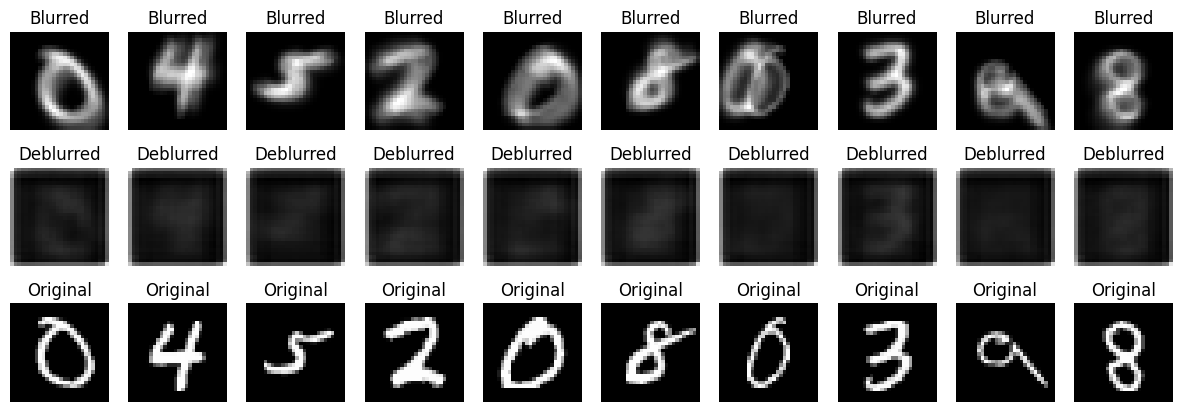

In [14]:
# Function to display images side by side for comparison
def display_comparison(blurred, deblurred, original, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Display blurred image
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(blurred[i].reshape(28, 28), cmap='gray')
        plt.title("Blurred")
        plt.axis('off')

        # Display deblurred image
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(deblurred[i].reshape(28, 28), cmap='gray')
        plt.title("Deblurred")
        plt.axis('off')

        # Display original image
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')
    plt.show()

# Display the comparison
display_comparison(validation_blurred, deblurred_images, validation_original)


# 8. Results Visualization

Visualizing the results is a key step in understanding the effectiveness of our deblurring model. This section will focus on comparing the blurred, deblurred, and original images, providing insights into the model's performance.

## 8.1. Detailed comparison of Images

To get a clearer picture of how our model performs, we'll display a set of images before and after deblurring, alongside their corresponding original images. This visual comparison helps in assessing the quality of the deblurring process.

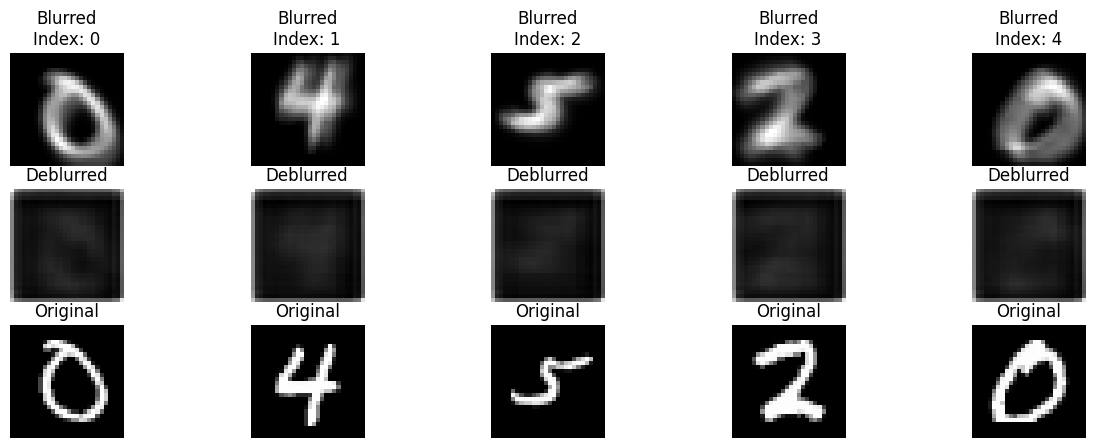

In [15]:
# Function for detailed comparison
def detailed_comparison(blurred, deblurred, original, indices):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        # Display blurred image
        ax = plt.subplot(3, len(indices), i + 1)
        plt.imshow(blurred[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Blurred\nIndex: {idx}")
        plt.axis('off')

        # Display deblurred image
        ax = plt.subplot(3, len(indices), i + 1 + len(indices))
        plt.imshow(deblurred[idx].reshape(28, 28), cmap='gray')
        plt.title("Deblurred")
        plt.axis('off')

        # Display original image
        ax = plt.subplot(3, len(indices), i + 1 + 2 * len(indices))
        plt.imshow(original[idx].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')
    plt.show()

# Select specific indices for detailed comparison
selected_indices = [0, 1, 2, 3, 4]  # You can choose different indices based on your dataset
detailed_comparison(validation_blurred, deblurred_images, validation_original, selected_indices)


## 8.2. Analysis of Results

After visualizing the comparisons, it's important to analyze the results. Consider the following points:

- How well does the model remove blur from the images?
- Are there any noticeable artifacts introduced by the deblurring process?
- How close are the deblurred images to the original images?

Reflect on these questions and any other observations you may have. This analysis will help in understanding the model's strengths and limitations.

# 9. Conclusion and Discusion